# Part II Learning a Cat
### Summary
This part will show intermediate visualization of convolution and pooling layers in a network (the output of a layer is often called its "activation", the output of the activation function). This gives another view of how an input is decomposed by different filters learned from the network. The input is a [1,150,150,3] image of cat. The model is trained through 2000 cats and dogs with sigmoid activation in the final dense layer. These feature maps we want to visualize have 3 dimensions: width, height, and depth (channels). Each channel encodes relatively independent features, so the proper way to visualize these feature maps is by independently plotting the contents of every channel, as a 2D image. The final trained model has training and testing error of 95% and 82% respectively. The model we use is referenced in "Visualizing what convnets learn" [[11]](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.4-visualizing-what-convnets-learn.ipynb).

### Data
The CNN model we designed is for a binary classification problem (cats and dogs). The small dataset we used is from Kaggle [[12]](https://www.kaggle.com/c/dogs-vs-cats/data). The original dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543MB large (compressed). We then use only 10% portion of this dataset to train our model to save time. The final manipulated dataset contains 4000 pictures of cats and dogs (2000 cats, 2000 dogs) with 2000 pictures for training, 1000 for validation, and finally 1000 for testing. This section references with "Using convnets with small datasets"[[13]](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.2-using-convnets-with-small-datasets.ipynb).

In [1]:
import keras
keras.__version__

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.2.4'

In [4]:
from keras import optimizers
from keras import layers
from keras import models

Since we are visualizing an input that comes from the same training set which the input images are heavily intercorrelated -- we cannot produce new information, we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight overfitting, we will add a Dropout layer to our model, right before the densely-connected classifier:

In [5]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [9]:
base_dir = '/Users/shilinli/Documents/GitHub/CNN-Feature-Visualization/data/cats_and_dogs_small'
train_dir = '/Users/shilinli/Documents/GitHub/CNN-Feature-Visualization/data/cats_and_dogs_small/train'
validation_dir = '/Users/shilinli/Documents/GitHub/CNN-Feature-Visualization/data/cats_and_dogs_small/validation'
test_dir = '/Users/shilinli/Documents/GitHub/CNN-Feature-Visualization/data/cats_and_dogs_small/test'

In [10]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

In [ ]:
model.save('cats_and_dogs_small_2.h5')

In [15]:
from keras.models import load_model

model = load_model('/Users/shilinli/Documents/GitHub/CNN-Feature-Visualization/output/cats_and_dogs_small_2.h5')

In [21]:
img_path = '/Users/shilinli/Documents/GitHub/CNN-Feature-Visualization/data/cats_and_dogs_small/test/cats/cat.1512.jpg'

# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


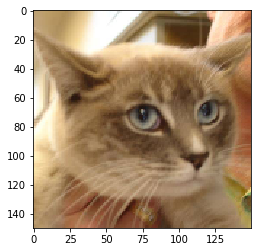

In [22]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In order to extract the feature maps we want to look at, we create a Keras model that takes batches of images as input, and outputs the activations of all convolution and pooling layers. To do this, we use the Keras class Model. A Model is instantiated using two arguments: an input tensor (or list of input tensors), and an output tensor (or list of output tensors). The resulting class is a Keras model, just like the Sequential models that you are familiar with, mapping the specified inputs to the specified outputs. 

In [23]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [24]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

The activation of the first convolutional layer transfers the dimension [1,150,150,3] to [1,148,148,32] in which it becomes 32 channels. We visualize the 3rd channel below. It seems the activation has a clear shape of the cats that it learns the edge or shape of the input image. From here, we can conclude that the activation contains almost all the information from the input image.

In [25]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


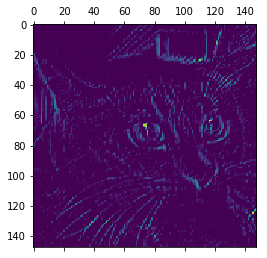

In [26]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

Next, we are visualizing every convolutional layer and pooling layer with all the channels displayed. In this way, we could observe the information learned by each layer and compare the difference between the activations. Before doing this experiment, we believe that each channel learned a small portion of the cats characteristics. The CNN in the training process records these characteristics. When an image of cat is fed, it activate different channel with the cats characteristics instead of dogs, which in return will drive the model to classify it as a cat.

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


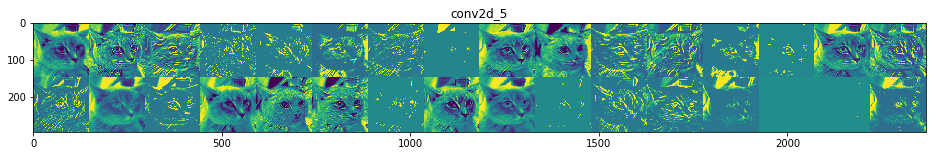

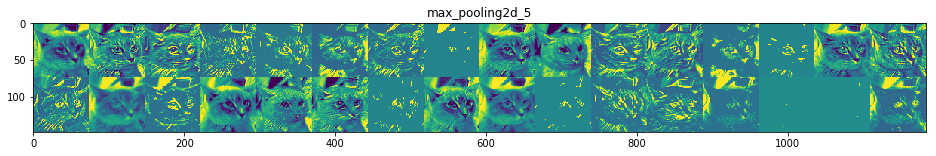

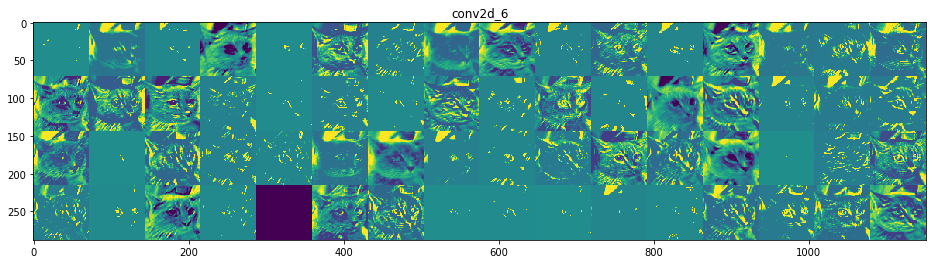

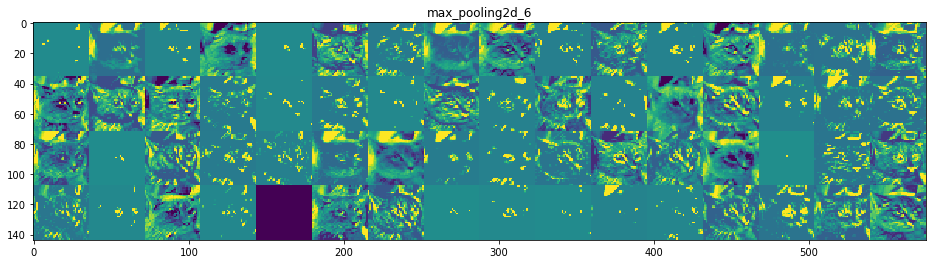

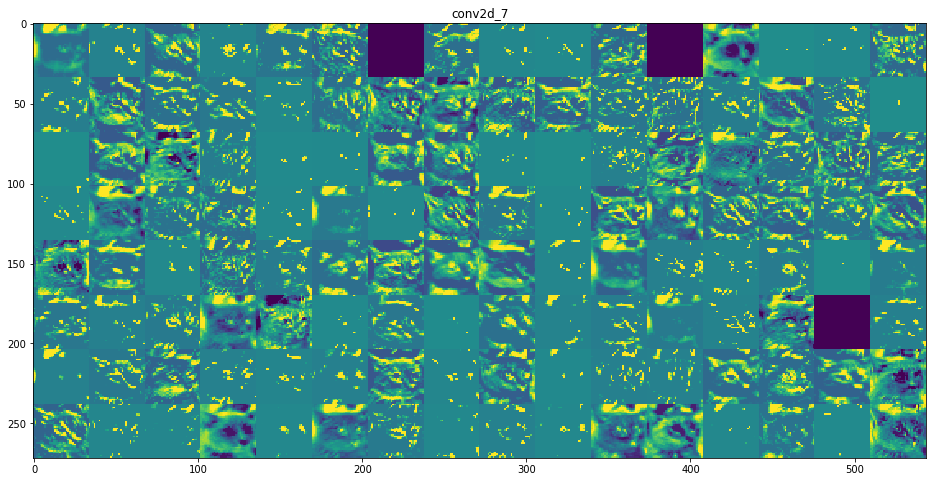

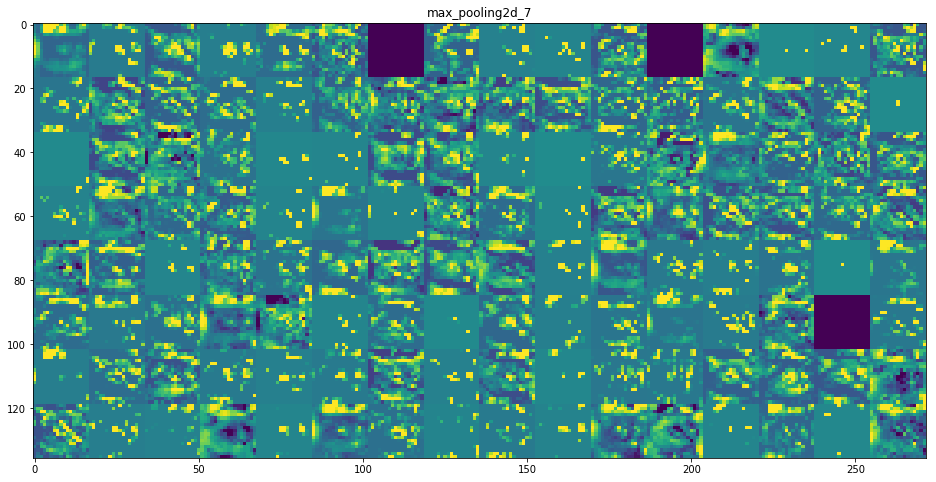

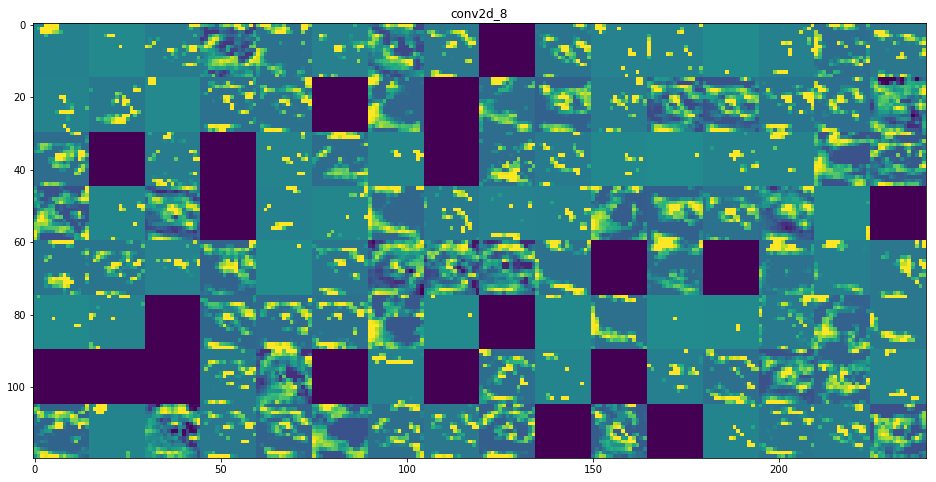

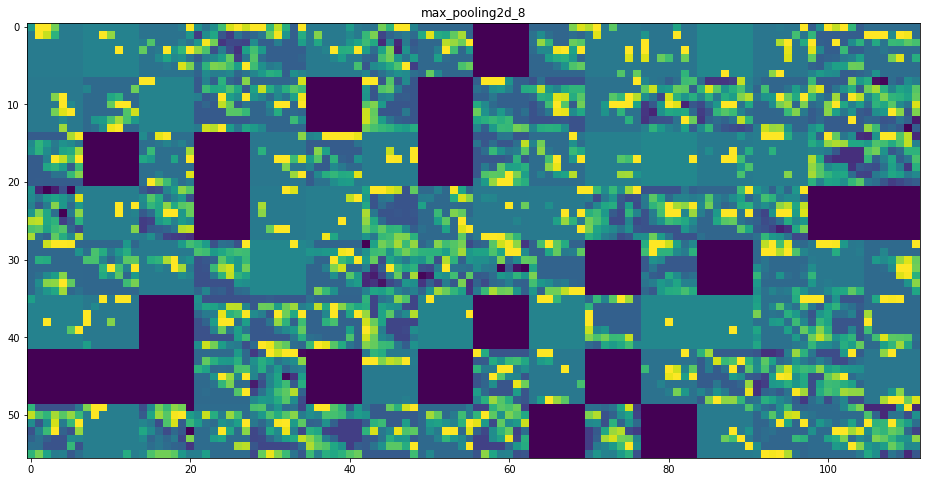

In [27]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

A few remarkable findings:

- The first layer acts as a collection of various edge detectors. At that stage, the activations are still retaining almost all of the information present in the initial picture.
- As we go higher-up, the activations become increasingly abstract and less visually interpretable. They start encoding higher-level concepts such as "cat ear" or "cat eye". Higher-up presentations carry increasingly less information about the visual contents of the image, and increasingly more information related to the class of the image.
- The sparsity of the activations is increasing with the depth of the layer: in the first layer, all filters are activated by the input image, but in the following layers more and more filters are blank. This means that the pattern encoded by the filter isn't found in the input image.

We have just evidenced a very important universal characteristic of the representations learned by deep neural networks: the features extracted by a layer get increasingly abstract with the depth of the layer. The activations of layers higher-up carry less and less information about the specific input being seen, and more and more information about the target (in our case, the class of the image: cat or dog). A deep neural network effectively acts as an information distillation pipeline, with raw data going in (in our case, RBG pictures), and getting repeatedly transformed so that irrelevant information gets filtered out (e.g. the specific visual appearance of the image) while useful information get magnified and refined (e.g. the class of the image).

This is analogous to the way humans and animals perceive the world: after observing a scene for a few seconds, a human can remember which abstract objects were present in it (e.g. bicycle, tree) but could not remember the specific appearance of these objects. In fact, when you tried to draw a generic bicycle from mind right now, chances are you could not get it even remotely right, even though you have seen thousands of bicycles. Our brain has learned to completely abstract its visual input, to transform it into high-level visual concepts while completely filtering out irrelevant visual details, making it tremendously difficult to remember how things around us actually look.